# End-to-end Multil-class Dog Breed Classification

## 1. Problem
Identifying the breed of a dog given an image of a dog.

## 2. Data

Dataset from Kaggle: https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

It's a file with prediction probabilities for each dog breed for each test image.

## 4. Features

Data info:
* Images (unstructured data).
* There are 120 breeds of dogs.
* There are around 10,000 images in the training set (images with labels).
* There are around 10,000 images in the test set (images without labels).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!unzip "drive/MyDrive/ML/DogBreed/dog-breed-identification.zip" -d "drive/MyDrive/ML/DogBreed/"

### Workspace Setup

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Checking for gpU availability
print("GPU", "available :)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.15.0
TF Hub version: 0.16.1
GPU available :)


## Transform our data into tensors (np arrays)

In [5]:
import pandas as pd

labels_csv = pd.read_csv("drive/MyDrive/ML/DogBreed/labels.csv")
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,fff43b07992508bc822f33d8ffd902ae,scottish_deerhound
freq,1,126


In [7]:
labels_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [8]:
labels_csv.isna().sum()

id       0
breed    0
dtype: int64

### How many images are there for each breed?

* Google recomends at least 10 for each class, the recommended is 100.

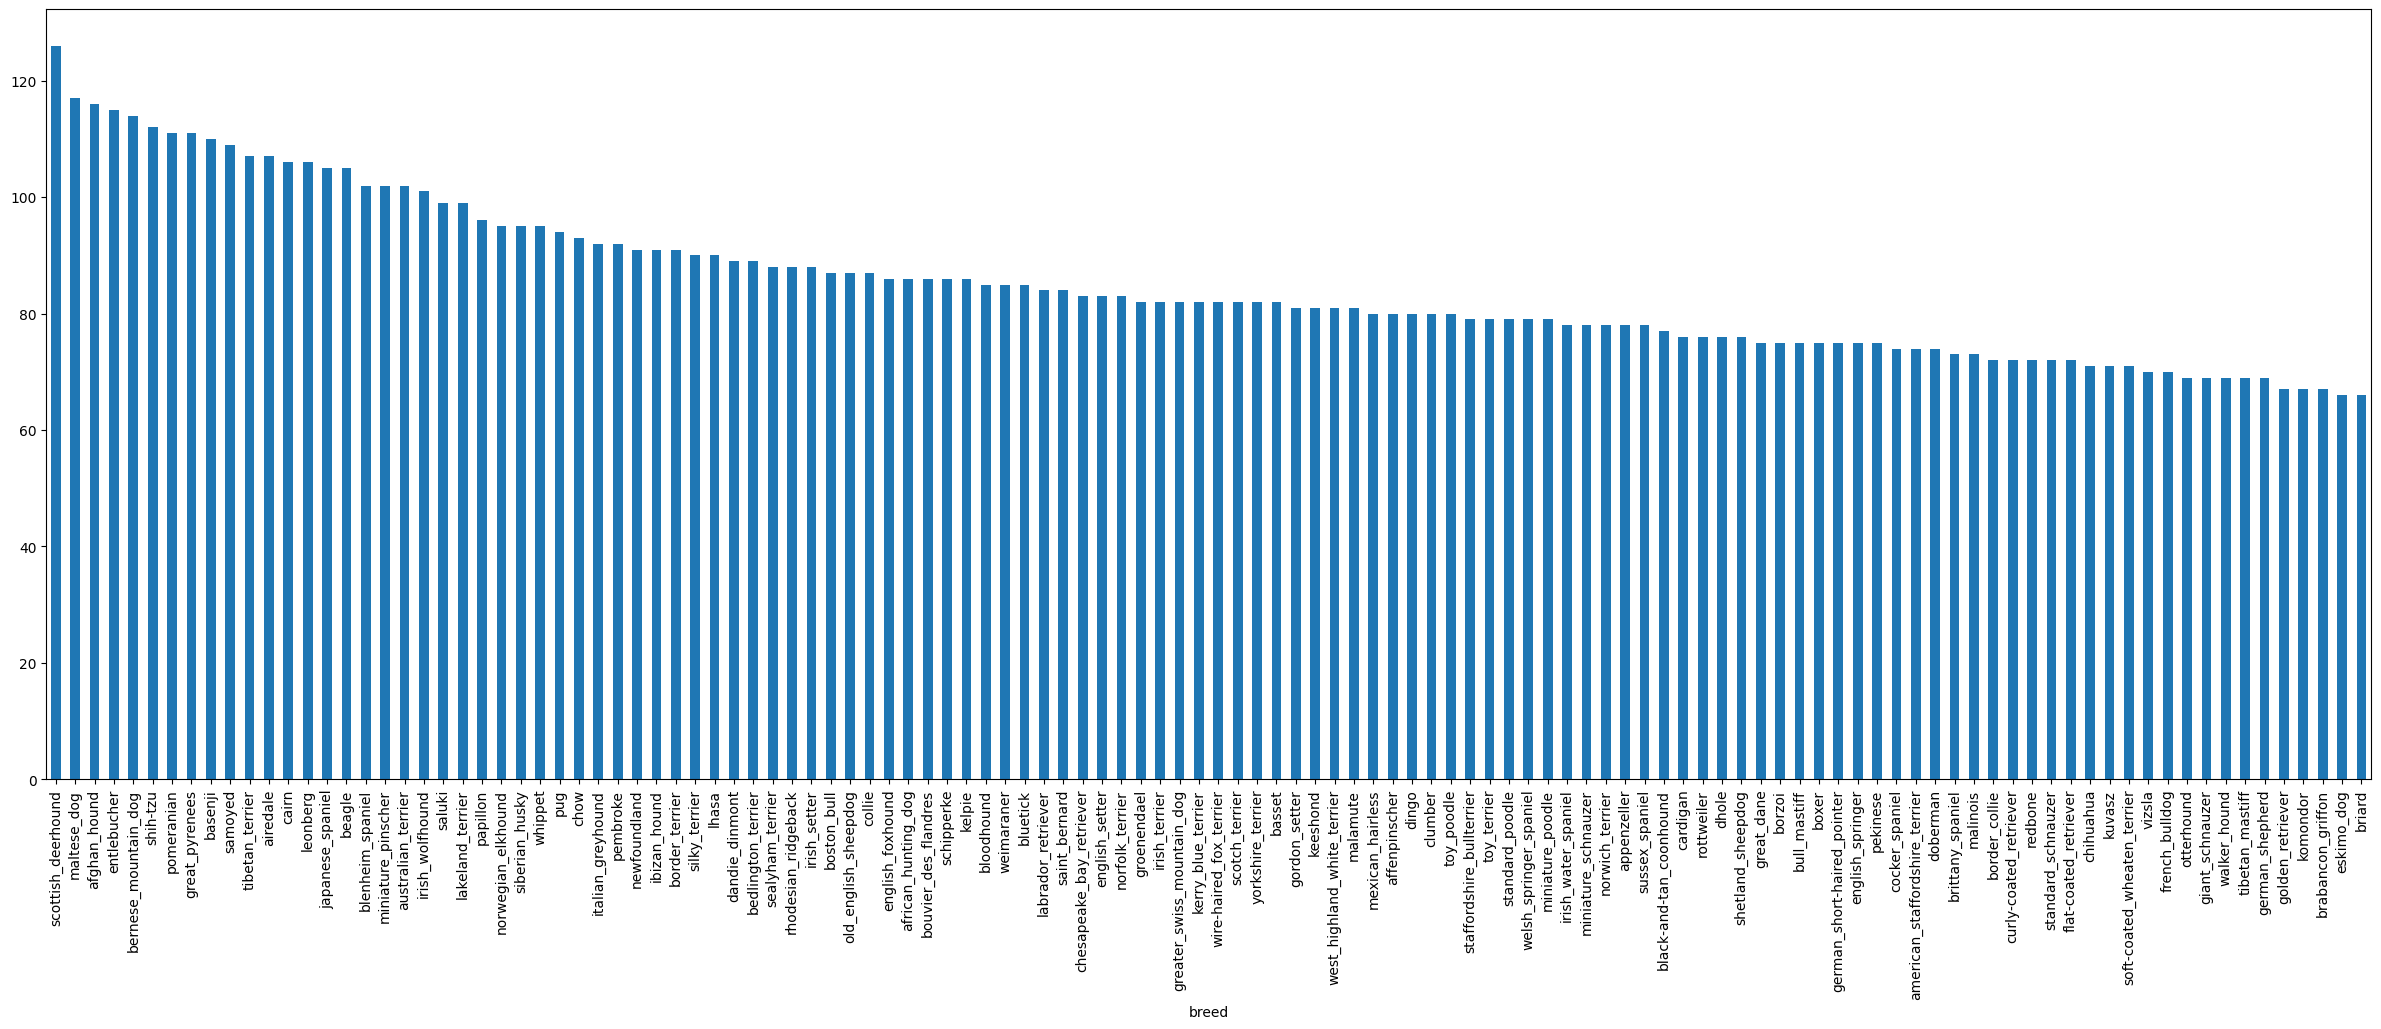

In [10]:
labels_csv["breed"].value_counts().plot.bar(figsize=(30, 10));

In [11]:
labels_csv["breed"].value_counts().median()

82.0

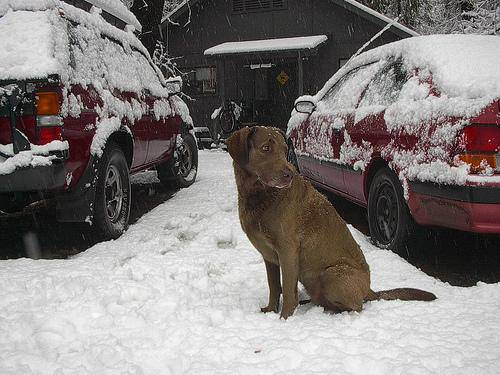

In [12]:
# Let's view an image
from IPython.display import Image

Image("drive/MyDrive/ML/DogBreed/train/fff43b07992508bc822f33d8ffd902ae.jpg")

### Getting images and their labels

In [14]:
filenames = ["drive/MyDrive/ML/DogBreed/train/" + fname + ".jpg" for fname in labels_csv["id"]]

filenames[:10]

['drive/MyDrive/ML/DogBreed/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/ML/DogBreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/ML/DogBreed/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/ML/DogBreed/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/ML/DogBreed/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/ML/DogBreed/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/ML/DogBreed/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/ML/DogBreed/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/ML/DogBreed/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/ML/DogBreed/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [15]:
# Checking if the number of filenames matches the number of actual image files
import os

if len(os.listdir("drive/MyDrive/ML/DogBreed/train/")) == len(filenames):
  print("Match")
else:
  print("Don't match")

Match


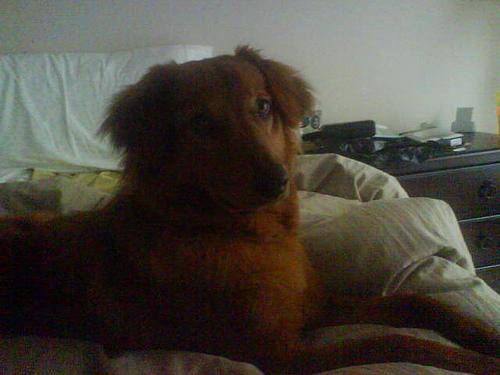

In [16]:
Image(filenames[1000])

In [17]:
import numpy as np

labels = np.array(labels_csv["breed"])

In [18]:
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [19]:
unique_breeds = np.unique(labels)
len(unique_breeds)

120

### Turning to numerical representation

In [20]:
labels[0] == unique_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [24]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:10]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
# Example: Turning boolean array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])) # Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

In [25]:
# Setup X and y
X = filenames
y = labels

Breaking up data for experimentation

In [27]:
# Hyperparameters are in capital
NUM_IMAGES =  1000 #@param {type:"slider", min:1000, max:10000}

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

In [30]:
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)